In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

In [2]:
# ---------------------------------------------------
# 匯入資料
columns_name = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','income']

data_train = pd.read_csv('adult.data', names=columns_name, header=None)
df_train = pd.DataFrame(data_train)

data_test = pd.read_csv('adult.test', names=columns_name, skiprows=1, header=None)
df_test = pd.DataFrame(data_test)

# ---------------------------------------------------
# missing value
columns_to_check = ['workclass', 'occupation', 'native-country']

df_train.replace(" ?", np.nan, inplace=True)
column_modes = df_train[columns_to_check].mode().iloc[0]
df_train.fillna(column_modes, inplace=True)

df_test.replace(" ?", np.nan, inplace=True)
column_modes = df_test[columns_to_check].mode().iloc[0]
df_test.fillna(column_modes, inplace=True)

# ---------------------------------------------------
# 將 income 轉換為 int64 (>50K:1；<=50K:0)

df_train.replace(" >50K", 1, inplace = True)
df_train.replace(" <=50K", 0, inplace = True)

df_test.replace(" >50K.", 1, inplace = True)
df_test.replace(" <=50K.", 0, inplace = True)

# ---------------------------------------------------
# Outlier

def detect_and_handle_Outlier(df, column_name, treshold=1.5):
    #IQR = Q3-Q1
    IQR = np.percentile(df[column_name],75) - np.percentile(df[column_name],25)
    #upper_outlier = Q3 + treshold*IQR 
    df=df[df[column_name] < np.percentile(df[column_name],75)+treshold*IQR]
    #lower_outlier = Q1 - treshold*IQR 
    df=df[df[column_name] > np.percentile(df[column_name],25)-treshold*IQR]
    return df

columns_to_check = ['age','education-num','hours-per-week','income']

for column in columns_to_check:
    df_train = detect_and_handle_Outlier(df_train, column)
    
for column in columns_to_check:
    df_test = detect_and_handle_Outlier(df_test, column)

In [3]:
# ---------------------------------------------------
# combine train and test data
df_data = pd.concat([df_train, df_test], axis=0)

# ---------------------------------------------------
# 移除無關屬性的欄位
# df_data.describe()
df_data.drop('fnlwgt', axis = 1, inplace = True)
df_data.drop('capital-gain', axis = 1, inplace = True)
df_data.drop('capital-loss', axis = 1, inplace = True)

# ---------------------------------------------------
# One Hot Encoding
df_data = pd.get_dummies(df_data)

# ---------------------------------------------------
# split train and test data
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]

# ---------------------------------------------------
# split feature and class
train_x = df_train.drop('income', axis=1)
train_y = df_train['income']

test_x = df_test.drop('income', axis=1)
test_y = df_test['income']

In [4]:
# ---------------------------------------------------
# 建立模型 CART
model = tree.DecisionTreeClassifier()

def CART_model(depth, leaf, top):
    # ---------------------------------------------------
    # 建立模型 CART
    model = tree.DecisionTreeClassifier(max_depth=depth, min_samples_leaf=leaf)

    # 訓練
    model.fit(train_x, train_y)

    # ---------------------------------------------------
    # 預測、評估模型好壞
    train_pred = model.predict(train_x)

    # 輸出混淆矩陣，顯示準確率
    print("Train: 輸出混淆矩陣，顯示準確率")
    print('====================================================================')
    print(confusion_matrix(train_y, train_pred))
    print(classification_report(train_y, train_pred))

    train_result = df_train[['income']].copy()
    train_result['predict'] = train_pred

    # train_result.to_excel('CART_train_result.xlsx', index=False)


    #預測，評估模型好壞
    test_pred = model.predict(test_x)

    #輸出混淆矩陣，顯示準確率：使用測試資料
    print("Test: 輸出混淆矩陣，顯示準確率")
    print('====================================================================')
    print(confusion_matrix(test_y, test_pred))
    print(classification_report(test_y, test_pred))

    test_result = df_test[['income']].copy()
    test_result['predict'] = test_pred

    # test_result.to_excel('CART_test_result.xlsx', index=False)
    
    
    # ---------------------------------------------------
    # ROC

    #將預測結果與真實資料 合併成 DataFrame
    from pandas import DataFrame
    df_PredResult = DataFrame({"Pred": test_pred, "Real":test_y})


    #將預測結果與真實資料 合併成DataFrame
    from pandas import DataFrame
    df_PredProb = DataFrame(model.predict_proba(test_x))
    df_myResult = pd.concat([df_PredResult, df_PredProb], axis=1)


    #Compute ROC curve and ROC area for each class
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    fpr,tpr,threshold = roc_curve(test_y, test_pred)
    roc_auc = auc(fpr,tpr)
    print("ROC_auc area=%.4f" % (roc_auc))



    # ---------------------------------------------------
    # PRC

    from sklearn.metrics import precision_recall_curve
    lr_precision, lr_recall, _ = precision_recall_curve(test_y, test_pred)

    from sklearn.metrics import f1_score
    lr_fl, lr_auc = f1_score(test_y, test_pred), auc(lr_recall, lr_precision)
    print("PRC_auc area=%.4f" % (lr_auc))
    
    # ---------------------------------------------------
    # 模型輸出，精緻圖形
    import graphviz
    dot_data = tree.export_graphviz(
                model, # (決策樹模型)
                out_file= None,
                feature_names= test_x.columns,
                filled= True,
                impurity= False,
                rounded= True
            )
    
    graph = graphviz.Source(dot_data) #選擇可視化的dot數據
    graph.format = 'png'
    
    
    graph.render('Top ' + str(top) + ' CART Dtree.gv')
    

    # ---------------------------------------------------
    # decision tree image
    import matplotlib.image as mpimg # mpimg 用於讀取圖片

    lena = mpimg.imread('Top ' + str(top) + ' CART Dtree.gv.png') #讀取和程式碼處於同一目錄下的 lena.png
    # 此時 lena 就已經是一個 np.array 了，可以對它進行任意處理
    lena.shape #(512, 512, 3)
    plt.imshow(lena) #顯示圖片
    plt.axis('off') #不顯示座標軸
    plt.show()

Rank 1: {'max_depth': 5, 'min_samples_leaf': 6}, Mean Test Accuracy: 0.8199758139183342
Train: 輸出混淆矩陣，顯示準確率
[[15237  1683]
 [ 2469  3507]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88     16920
           1       0.68      0.59      0.63      5976

    accuracy                           0.82     22896
   macro avg       0.77      0.74      0.75     22896
weighted avg       0.81      0.82      0.81     22896

Test: 輸出混淆矩陣，顯示準確率
[[7715  849]
 [1212 1728]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      8564
           1       0.67      0.59      0.63      2940

    accuracy                           0.82     11504
   macro avg       0.77      0.74      0.75     11504
weighted avg       0.81      0.82      0.82     11504

ROC_auc area=0.7443
PRC_auc area=0.6818


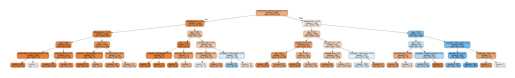

Rank 2: {'max_depth': 5, 'min_samples_leaf': 5}, Mean Test Accuracy: 0.8199758139183342
Train: 輸出混淆矩陣，顯示準確率
[[15237  1683]
 [ 2469  3507]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88     16920
           1       0.68      0.59      0.63      5976

    accuracy                           0.82     22896
   macro avg       0.77      0.74      0.75     22896
weighted avg       0.81      0.82      0.81     22896

Test: 輸出混淆矩陣，顯示準確率
[[7715  849]
 [1212 1728]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      8564
           1       0.67      0.59      0.63      2940

    accuracy                           0.82     11504
   macro avg       0.77      0.74      0.75     11504
weighted avg       0.81      0.82      0.82     11504

ROC_auc area=0.7443
PRC_auc area=0.6818


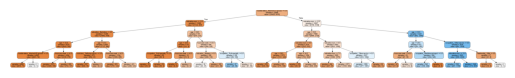

Rank 3: {'max_depth': 5, 'min_samples_leaf': 2}, Mean Test Accuracy: 0.819888857396595
Train: 輸出混淆矩陣，顯示準確率
[[15237  1683]
 [ 2467  3509]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88     16920
           1       0.68      0.59      0.63      5976

    accuracy                           0.82     22896
   macro avg       0.77      0.74      0.75     22896
weighted avg       0.81      0.82      0.81     22896

Test: 輸出混淆矩陣，顯示準確率
[[7715  849]
 [1211 1729]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      8564
           1       0.67      0.59      0.63      2940

    accuracy                           0.82     11504
   macro avg       0.77      0.74      0.75     11504
weighted avg       0.81      0.82      0.82     11504

ROC_auc area=0.7445
PRC_auc area=0.6820


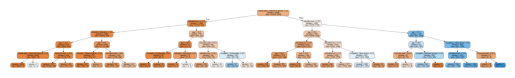

In [5]:
# ---------------------------------------------------
# grid search
param_grid = [
{'min_samples_leaf': range(1, 30), 'max_depth': range(1, 30)},
]
 
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5)
 
grid_search.fit(test_x, test_y)

# 取得所有參數組合的評估績效
results = grid_search.cv_results_
mean_test_accuracy = results['mean_test_score']

# 排序 accuracy，找到 Top3 的 accuracy
top_k = 3
sorted_indices = np.argsort(mean_test_accuracy)[::-1][:top_k]
results = grid_search.cv_results_
mean_test_accuracy = results['mean_test_score']

# 排序 accuracy，找到 Top3 的 accuracy
top_k = 3
sorted_indices = np.argsort(mean_test_accuracy)[::-1][:top_k]

# 取得 Top3 的參數組合和 mean accuracy
top_k_params = [results['params'][i] for i in sorted_indices]
top_k_scores = [mean_test_accuracy[i] for i in sorted_indices]

for i in range(top_k):
    print(f"Rank {i + 1}: {top_k_params[i]}, Mean Test Accuracy: {top_k_scores[i]}")
    CART_model(top_k_params[i]['max_depth'],top_k_params[i]['min_samples_leaf'], i+1)